### 0 - Refresher on calculus

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

Let's create a quadratic function to apply on an array and plot its corresponding parabola

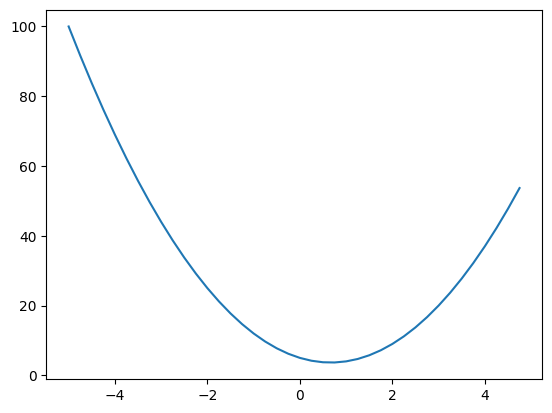

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

Let's now evaluate the derivative of this function numerically.<br>
The "intensity' of the slope of the derivated function measures the sensitivity with which the function response to a tiny change in its value.

In [4]:
# we set the tiny change h very small
h  = 0.001
# and set a point x at 3.0 where f(x) grows wrt x
x = 3.0
# then compute the derivative at x
(f(x+h) - f(x)) / h

14.00300000000243

The derivative of `f(x)` at `x` noted `f'(x)` is the slope of the line that passes through the coordinates `(x,f(x))` and `(x+h,f(x+h))`.<br>
Read it as "the sensitivity of `f(x)` to `x`".<br>
Where `f(x)` increases wrt `x`, the slope will be positive.

In [5]:
# or at -3.0 where f(x) decreases wrt x
x = -3.0
(f(x+h) - f(x)) / h

-21.996999999998934

While where `f(x)` decreases wrt `x`, the slope will be negative.<br>
And where `f(x)` stabilizes wrt `x`, the slope will approach 0:

In [6]:
x = 2/3
(f(x+h) - f(x)) / h

0.0029999999995311555

More precisely if we want to measure a function sensitivity wrt to a variable we can:

In [7]:
# set inputs
a = 2.0
b = -3.0
c = 10.0

# create function d
d1 = a*b+c
# bump a by h
a += h
# create function corresponding to a bump by h
d2 = a*b+c

# print the slope
print('d1 =', d1)
print('d2 =', d2)
print('slope =', (d2-d1)/h)

d1 = 4.0
d2 = 3.997
slope = -3.0000000000001137


Slope approx `b` value as derivating `d = a.b + c` wrt `a` gives `b`.

In [8]:
# if we bump b by h now
a = 2.0
b += h
d2 = a*b+c
# print the slope
print('d1 =', d1)
print('d2 =', d2)
print('slope =', (d2-d1)/h)

d1 = 4.0
d2 = 4.002
slope = 1.9999999999997797


Approxing `a` value as derivating `d = a.b + c` wrt `b` gives `a`.

### I - Implementing Backpropagation

#### 1 - Manually

##### i - Prerequisites
Start to create the main class Value

In [9]:
class Value:

    # takes single value that it wraps and keeps track of
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        # set for optimization in showing the children of the value for operations
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # allows to print the value
    def __repr__(self):
        return f"Value(data={self.data})"

    # allows to add two values together
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    # allows to multiply two values together
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out
    
    # allows to compute tanh of a value
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        return out

In [10]:
# instantiate intial values
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
# compute some more
d = a * b + c; d.label = "d"

In [11]:
print('d =', d)
print('d._prev =', d._prev)
print('d._op =', d._op)
print('d.label =', d.label)
print('d.grad = ', d.grad)

d = Value(data=4.0)
d._prev = {Value(data=-6.0), Value(data=10.0)}
d._op = +
d.label = d
d.grad =  0.0


Add vizualisation tool

In [12]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


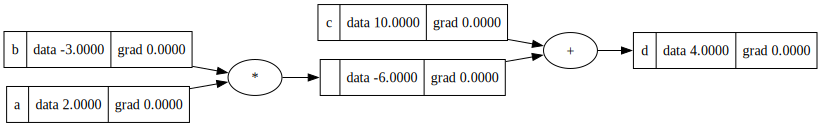

In [13]:
draw_dot(d)

In [14]:
# deepen the graph with new values
e = a * b; e.label = "e"
f = e + c; f.label = "f"
g = Value(-2.0, label="g")
L = f * g; L.label = "L"

In [15]:
print(e.label,'=', e)
print(f.label,'=', f)
print(g.label,'=', g)
print(L.label,'=', L)

e = Value(data=-6.0)
f = Value(data=4.0)
g = Value(data=-2.0)
L = Value(data=-8.0)


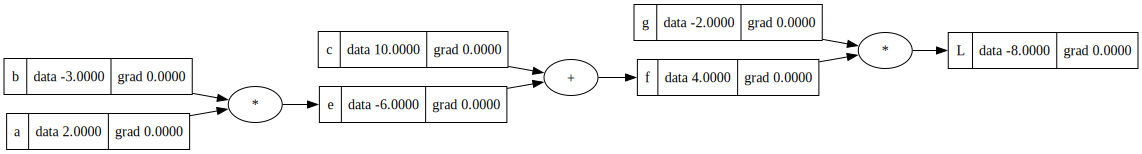

In [16]:
draw_dot(L)

We are vizualising the forward pass of a mathematical expression only composed of additions and multiplications.<br>

##### ii - Manual implementation from scratch

Now we want to run backpropagation by reverting the graph and calculate the gradient at each step.<br>
Read it as `L` being the loss function and some of the other letters eventually being the weights of the nn: we are interested in the derivative of the output wrt some of its 'leaf nodes', those being the weights of the nn.<br>The other leaf nodes will be the data itself which is fixed contrary to the weights that will be iterated on.<br>
So we are going to compute the derivative of `L` wrt to every other letter from `g` back to `a` so we know how the weights are impacting the loss function.<br>

In [17]:
# manually set the derivative of L wrt to itself to 1 (dL/dL = 1)
L.grad = 1.0
# dL/df = g
f.grad = g.data
# dL/dg = f
g.grad = f.data

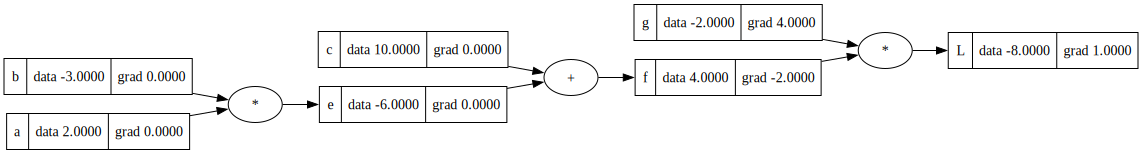

In [18]:
draw_dot(L)

We want to know if `c` impacts `L` through `f`.<br>
Now `f` being an addition, we know that the (local) derivatives of `f` wrt `c` is `1` and that symetrically the (local) derivatives of `f` wrt `e` is also `1`.<br>
We apply the chain rule to get the global derivatives of `L` wrt `c` and `e`.




In [19]:
# chain rule states that dL/dc = dL/df * df/dc = g * 1 = g = -2.0
c.grad = g.data
# and dL/de = dL/df * df/de = g * 1 = g = -2.0
e.grad = g.data

In [20]:
# Additionally, dL/da = dL/de * de/da = g * b = -2.0 * -3.0 = 6.0
a.grad = g.data * b.data
# and dL/db = dL/de * de/db = g * a = -2.0 * 2.0 = -4.0
b.grad = g.data * a.data

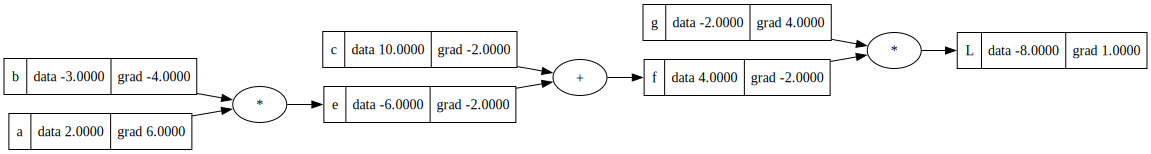

In [21]:
draw_dot(L)

##### iii - in the context of a neuron

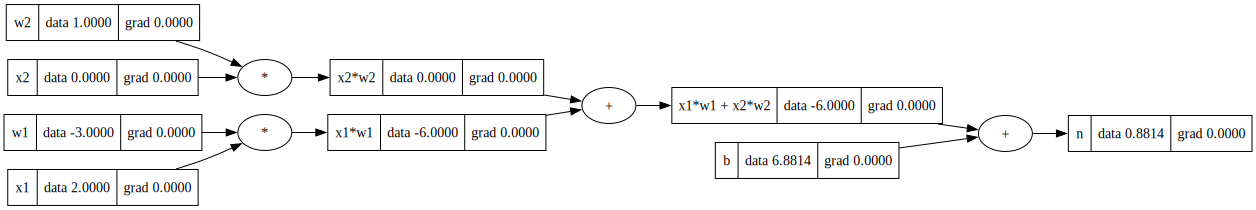

In [22]:
# set inputs x1 and x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# set weights w1 and w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# set bias (arbitrary precise value of b so that gradients are simple, memorizable numbers)
b = Value(6.8813735870195432, label="b")
# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

draw_dot(n)

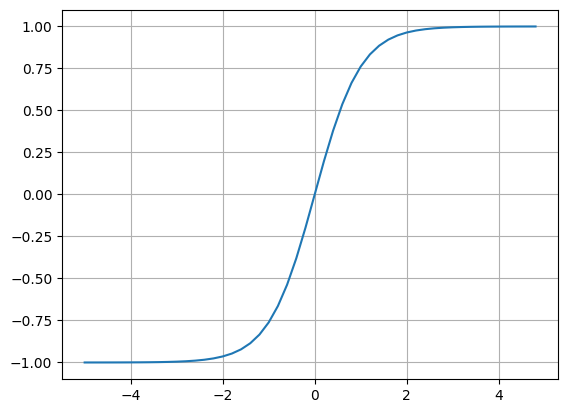

In [23]:
# we chose the output function to be tanh, simple yet common
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

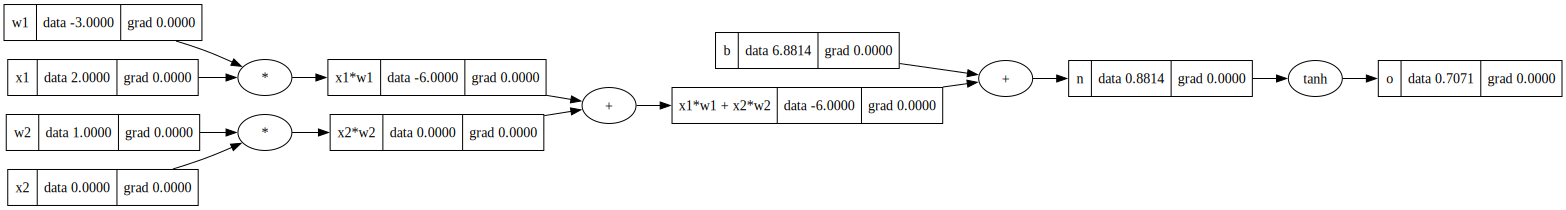

In [24]:
# set the output
o = n.tanh(); o.label = "o"
draw_dot(o)

By notching up the bias `b` we see the output value passed through `tanh` function to converge towards its max value of `1`.<br>
Now start the backpropagation by computing the derivatives at steps by applying the chain rule:

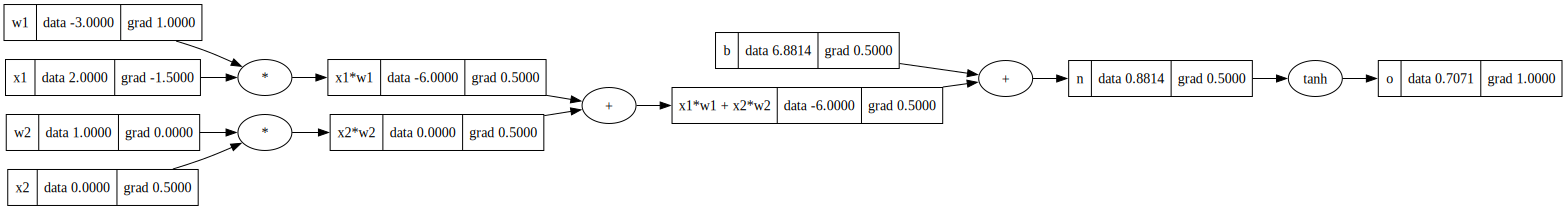

In [25]:
# for addition operators incoming gradients are passed through as:
# do/do = 1
o.grad = 1.0
# do/dn = 1 - tanh(n)^2 = 1 - o^2
n.grad = 1 - o.data**2
# do/db = do/dn * dn/db = (1 - o^2) * 1 = 1 - o^2
b.grad = n.grad
# do/dx1w1x2w2 = do/dn * dn/dx1w1x2w2 = (1 - o^2) * 1 = 1 - o^2
x1w1x2w2.grad = n.grad
# do/dx1w1 = do/dx1w1x2w2 * dx1w1x2w2/dx1w1 = (1 - o^2) * 1 = 1 - o^2
x1w1.grad = x1w1x2w2.grad
# do/dx2w2 = do/dx1w1x2w2 * dx1w1x2w2/dx2w2 = (1 - o^2) * 1 = 1 - o^2
x2w2.grad = x1w1x2w2.grad

# for multiplication operators compute local derivative * incoming gradient
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

#### 2 - Python-based implementation

##### i - Compute every backpropagation step automatically
Reimplement de Value class with backpropagation capabilities

In [59]:
class Value:

    # takes single value that it wraps and keeps track of
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        # function to compute chain ruled gradients
        self._backward = lambda: None
        # set for optimization in showing the children of the value for operations
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # prints value.data
    def __repr__(self):
        return f"Value(data={self.data})"

    # adds self + other
    def __add__(self, other):
        # for convenience in adding non Value objects, if other is not a Value object, convert it to one
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        # compute the gradients in the context of an addition operation
        def _backward():
            # we increment ('+=') so we take into account multiple paths to the same value (multivariate chain rule)
            # which is OK as long as we initialize the gradient to 0.0 at the beginning of the backward pass
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    # default addition when unilateral sense is not respected: other + self
    def __radd__(self, other):
        return self + other

    # substracts by negation
    # we first implement a negation function: -self
    def __neg__(self):
        return -1.0 * self
    
    # then we can use the negation function to implement substraction: self - other
    def __sub__(self, other):
        return self + (-other)

    # multiplies self * other
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    # default multiplication when unilateral sense is not respected
    # other * self when self * other cannot be processed
    def __rmul__(self, other):
        return self * other
    
    # computes division as special case of a more general operation
    # we first need a power function: self**other
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward

        return out

    # then implement the division: self/other
    def __truediv__(self, other):
        return self * other**-1
    
    # computes tanh of a value
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
                
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    # computes exponentiation
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # set a topological sort algorithm
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

Reset values and grads

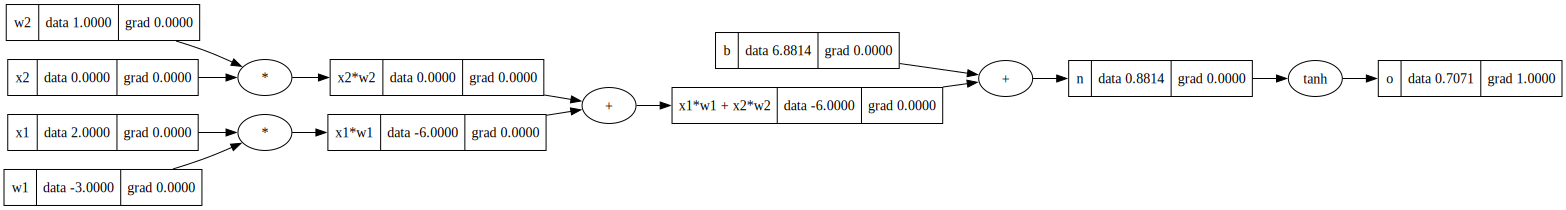

In [56]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")
# values
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# output
o = n.tanh(); o.label = "o"
# initialize output grad value as the first grad
o.grad = 1.0

draw_dot(o)

Call the backward functions

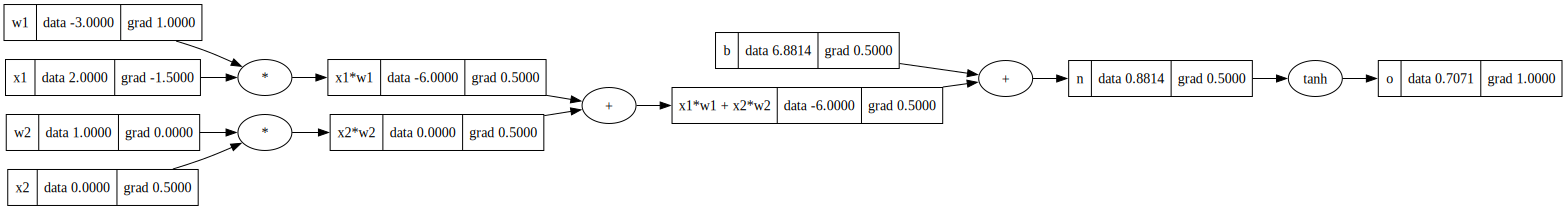

In [ ]:
# call the backward functions
# first of the output
o._backward()
# then of the rest
n._backward()
# b does not have a backward
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

##### ii - Automate backpropagation function calls
Before computing backpropagating from a node to its leaf nodes, we need to ensure every preceding steps have been achieved already, that every preceding backpropagations have been processed up to this node.<br>
This 'ordering' of graphs can be achieved through 'topological sort' which is a layout of graphs from left to right.

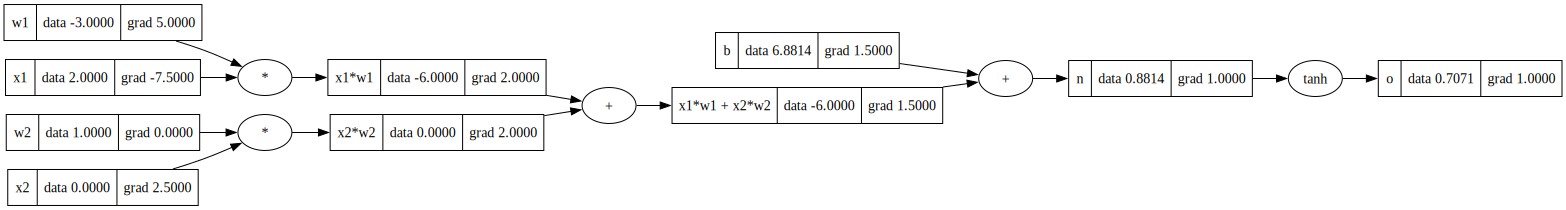

In [29]:
# Set a topological sort algorithm
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

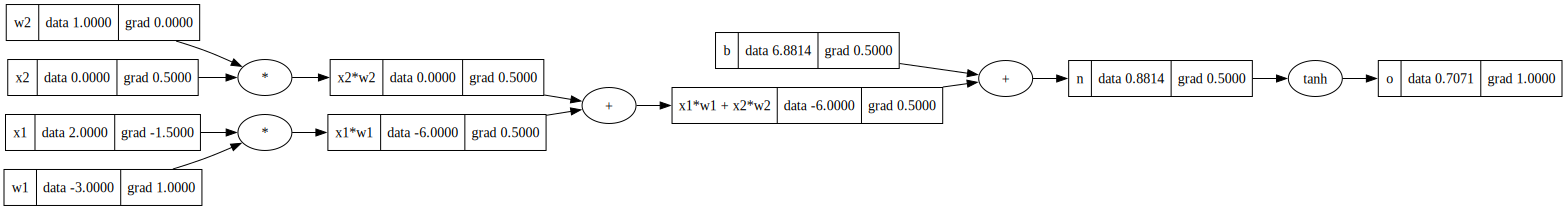

In [57]:
# once topological sort algorithm is integrated in Value class
# just call the new backward function on the output
o.backward()

draw_dot(o)

##### iii - Additional features to the Value class

* increment gradients storage instead of storing them once, allowing the workaround the bug of 2 variables with same name in operators;
* conversion of non-Value objects to Value objects to allow unilateral operations: `<object> -> <operator> -> <value>`:<br>
```python
other = other if isinstance(other, Value) else Value(other)
```
* addition of fallback operations if contrary to unilateral sense: `<value> -> <operator> -> <object>`:<br>
```python
def __rmul__(self, other):
    return self * other
```
* exponentiation operation;
* division operation.

Now to test the implementation of these features, we decompose tanh(x) into suboperations:


In [60]:
# we reset the values again
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")
# values
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# original output
o = n.tanh(); o.label = "o"
# but we decompose it as the sum of the exponentiations
e = (2 * n).exp(); e.label = "e"
o = (e - 1) / (e + 1); o.label = "o"
o.backward()

Expected graph should be bigger because of `tanh` replaced by `exp` and `add` but grad values should be conserved:

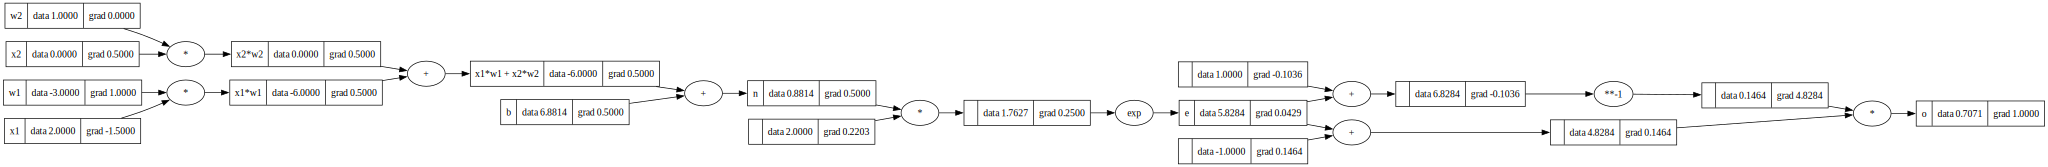

In [61]:
draw_dot(o)

#### 3 - PyTorch-based implementation

In [67]:
import torch
import random

In [63]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Values appear the same thus validating our manual implementations earlier.<br>
PyTorch leverages the `tensor` object capabilities in order to produce massive parallelized computations on n-dimension vectors with best efficiency.

#### 4 - Building neural nets

##### i - Simple Neuron

In [147]:
class Neuron:
    
    # constructor takes number of inputs to the neuron 'nin'
    def __init__(self, nin):
        # weights
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # bias controlling overall 'trigger happiness' of the neuron
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        # raw activation function
        # with b value as the start of the sum instead of default 0.0 for efficiency
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # to be passed in non-linearity
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9583729894725803)

##### ii - Layer of Neurons
A layer of neurons is a set of neurons independant from each other.

In [148]:
class Layer:

    # 'nin' as number of inputs and 'nout' as number of neurons in a single layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.4099685265201124),
 Value(data=-0.8785116893497118),
 Value(data=-0.9847597558673783)]

##### iii - Multi Layer Perceptron (MLP)
In a MLP, neuron layers feed into each other sequentially.

In [149]:
class MLP:

    # 'nin' as number of inputs and 'nouts' as number of neurons in each layer listifying the size of each layer in the MLP
    def __init__(self, nin, nouts):
        # put all together in a list
        sz = [nin] + nouts
        # iterate over consecutive pairs of defined sizes and create Layer objects for them
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    # call them sequentially
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# 3-dimensional input
x = [2.0, 3.0, -1.0]
# 3 inputs into 2 layers of 4 neurons each and 1 output neuron
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.14212724453212253)

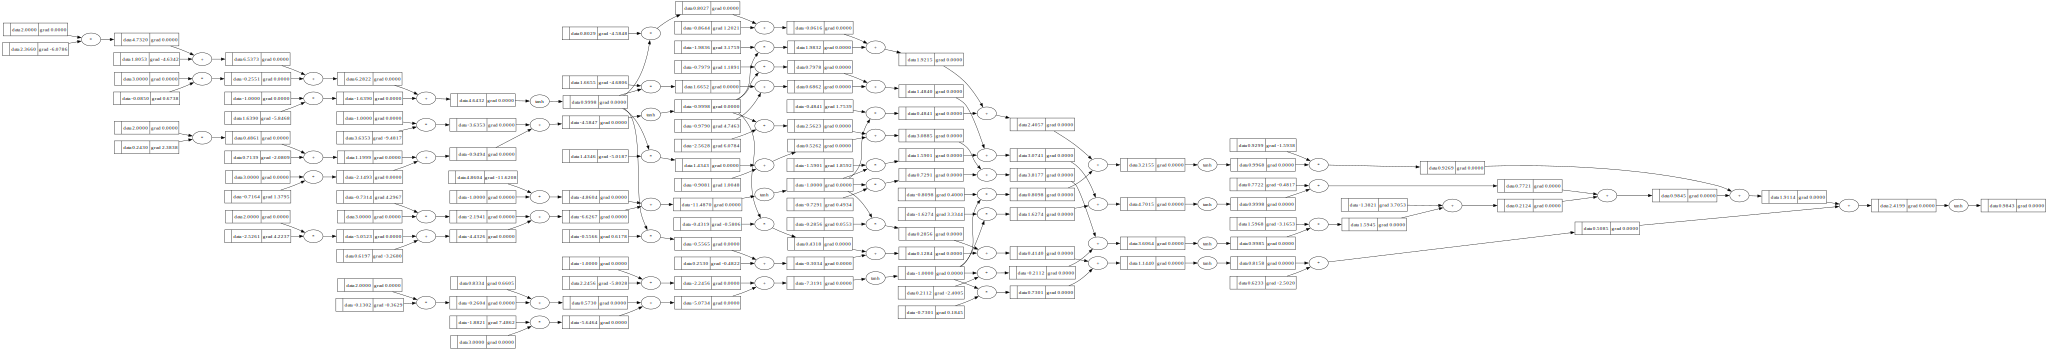

In [197]:
draw_dot(n(x))

Now we need to leverage `micrograd` to backpropagate along all the weights `w` of these neurons.

##### iv - Tiny dataset & loss function
The dataset 
* has 4 examples so 4 possible inputs in the nn, 
* and 4 desired targets.

In [151]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# show outputs of the nn on these 4 example inputs
ypred = [n(x) for x in xs]
ypred

[Value(data=0.14212724453212253),
 Value(data=0.9009580588734983),
 Value(data=0.26786014109737794),
 Value(data=0.6552373901641595)]

Outputs of the nn are way off the desired targets.<br>
To make it converge we leverage the `loss` which is a single number that measures the total performance of the nn.<br>
Here the `loss` will be high and we want to minize it.

In [111]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.843353647985428)

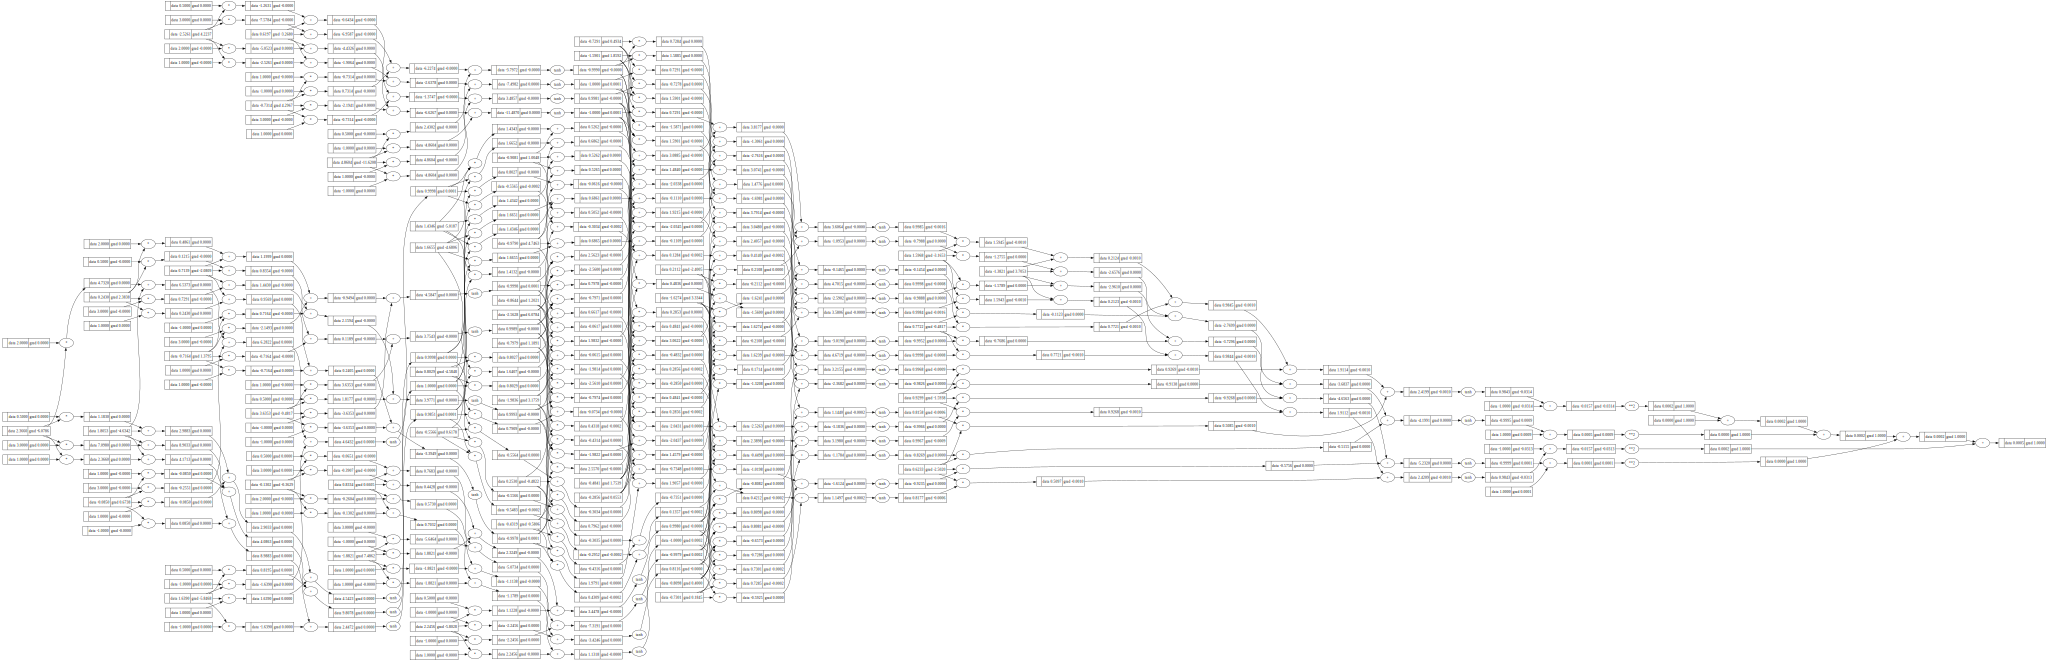

In [199]:
draw_dot(loss)

In [ ]:
# we can run the backprop on the loss to compute all gradients already
loss.backward()

0.39263352022755454

In [ ]:
# and check coherence of the gradients by taking an example
print('neuron 0 value =', n.layers[0].neurons[0].w[0].data)
print('neuron 0 grad value =', n.layers[0].neurons[0].w[0].grad)

neuron 0 value = -0.49698497020148125
neuron 0 grad value = 0.39263352022755454


See the gradient as a vector that points towards the maximization of the loss.<br>
Our objective being lowering the loss, which means overall performance of the nn increases, we need to take the negative value of the gradient in order to minimize the loss.

In [ ]:
# taking the opposite 'direction' of the gradient
for p in n.parameters():
    p.data += -0.01 * p.grad

Value(data=4.843353647985428)

Now displaying the entire cycle:

In [193]:
# run a forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.0004917789493880773)

In [194]:
# run the backward pass
loss.backward()

In [192]:
# run a step size again
for p in n.parameters():
    p.data += -0.1 * p.grad

In [195]:
# check predicted values to see if they are closer to the target
ypred

[Value(data=0.9843076092300288),
 Value(data=-0.9995495895118557),
 Value(data=-0.9999429062463338),
 Value(data=0.9843372514542925)]

In [200]:
# with its corresponding weights and biases values corresponding to way better predictions capabilities of our nn
n.parameters()

[Value(data=2.36599399707707),
 Value(data=-0.08503805864030486),
 Value(data=1.639024022302521),
 Value(data=1.8053096919773803),
 Value(data=0.2430415365849946),
 Value(data=-0.7164402299364144),
 Value(data=3.635317541834586),
 Value(data=0.7138529508153708),
 Value(data=-2.5261427885927543),
 Value(data=-0.731355147556552),
 Value(data=4.860398520325706),
 Value(data=0.6196997289350687),
 Value(data=-0.130220330513298),
 Value(data=-1.8821499988162917),
 Value(data=2.2456339528543845),
 Value(data=0.8334449072827722),
 Value(data=1.4345590319087302),
 Value(data=-2.5627972147920253),
 Value(data=-0.7291463894016615),
 Value(data=0.21121687939483505),
 Value(data=-0.908051706835595),
 Value(data=1.6654781728486143),
 Value(data=-0.7979486320315088),
 Value(data=-1.5901184853630808),
 Value(data=-1.6273809724841484),
 Value(data=-0.9789947140791622),
 Value(data=0.802866643478666),
 Value(data=-1.983590889125723),
 Value(data=-0.4841289271329455),
 Value(data=-0.8098259914190191),
 V

##### v - Training loop

Reset our nn

In [204]:
# 3-dimensional input
x = [2.0, 3.0, -1.0]
# 3 inputs into 2 layers of 4 neurons each and 1 output neuron
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5607614558470567)

Then setup our training loop

In [210]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    # reseting all gradients first
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data += -0.1 * p.grad

    # print current loss
    print(k, loss.data)

0 0.01828086369776322
1 0.017543730584861077
2 0.01686064702838754
3 0.016225976863255907
4 0.015634835656535406
5 0.015082969861479204
6 0.014566658514551172
7 0.014082632722153866
8 0.013628009295094197
9 0.013200235716218178
10 0.012797044248483339
11 0.012416413462217626
12 0.012056535820776548
13 0.011715790241549374
14 0.011392718764847697
15 0.011086006631713139
16 0.010794465204250321
17 0.010517017267048984
18 0.010252684331841122
19 0.01000057563447819


In [209]:
ypred

[Value(data=0.9471862600190069),
 Value(data=-0.9053511496944008),
 Value(data=-0.9765880221891371),
 Value(data=0.9201757273899088)]